In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Load datasets
matches = pd.read_csv("/content/matches.csv")
deliveries = pd.read_csv("/content/deliveries.csv")


In [ ]:


# Clean column names
matches.columns = matches.columns.str.strip().str.lower()
deliveries.columns = deliveries.columns.str.strip().str.lower()

# Convert 'season' to int
matches['season'] = pd.to_numeric(matches['season'], errors='coerce')
matches.dropna(subset=['season'], inplace=True)
matches['season'] = matches['season'].astype(int)

# Drop null match winners (e.g., abandoned)
matches = matches[~matches['winner'].isna()]

# Clean extra spaces
for col in ['team1', 'team2', 'winner']:
    matches[col] = matches[col].str.strip()
for col in ['batting_team', 'bowling_team', 'batter', 'bowler']:
    deliveries[col] = deliveries[col].str.strip()

# Filter for seasons 2020 to 2024
matches_filtered = matches[matches["season"].between(2020, 2024)]
match_ids = matches_filtered["id"].unique()
deliveries_filtered = deliveries[deliveries["match_id"].isin(match_ids)]

# Merge deliveries with matches
deliveries_merged = deliveries_filtered.merge(
    matches_filtered[['id', 'season', 'venue', 'winner']],
    left_on='match_id',
    right_on='id',
    how='left'
)

<ipython-input-2-292051b4bd13>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches[col] = matches[col].str.strip()


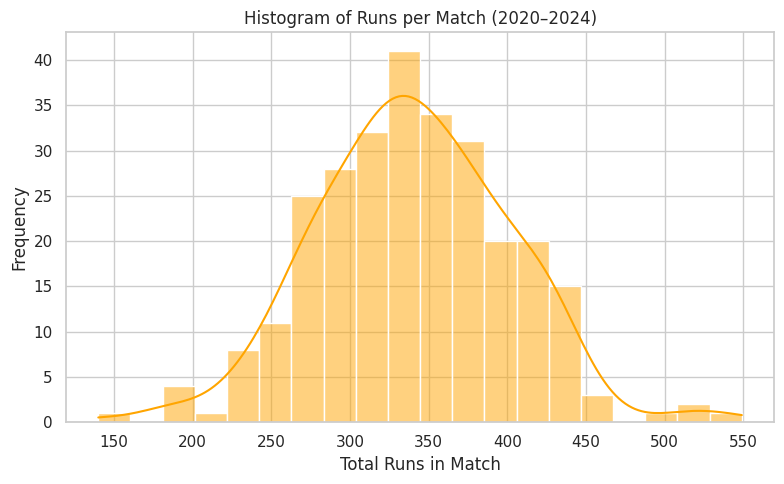

In [ ]:
# 1. 🧃 Histogram of total runs in matches
runs_per_match = deliveries_merged.groupby('match_id')['total_runs'].sum()
plt.figure(figsize=(8, 5))
sns.histplot(runs_per_match, bins=20, kde=True, color='orange')
plt.title("Histogram of Runs per Match (2020–2024)")
plt.xlabel("Total Runs in Match")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

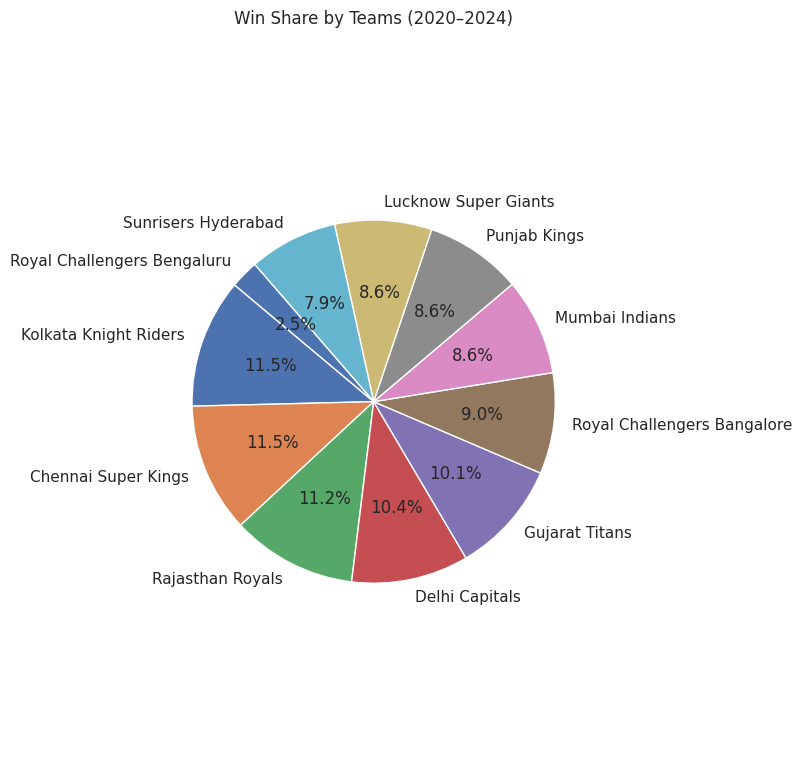

In [ ]:
# 2. 🥧 Pie Chart – Win share
win_share = matches_filtered['winner'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(win_share, labels=win_share.index, autopct='%1.1f%%', startangle=140)
plt.title("Win Share by Teams (2020–2024)")
plt.axis('equal')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

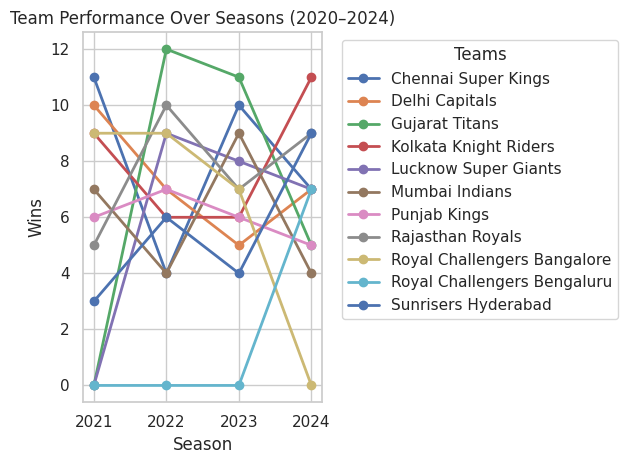

In [ ]:
# 3. 📈 Team performance over seasons (line chart)
team_performance = matches_filtered.groupby(['season', 'winner']).size().reset_index(name='wins')
pivot_perf = team_performance.pivot(index='season', columns='winner', values='wins').fillna(0)
plt.figure(figsize=(12, 6))
pivot_perf.plot(marker='o', linewidth=2)
plt.title("Team Performance Over Seasons (2020–2024)")
plt.xlabel("Season")
plt.ylabel("Wins")
plt.legend(title="Teams", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-6-b318c0aca799>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=total_runs_season, x='season', y='total_runs', palette='Blues_d')


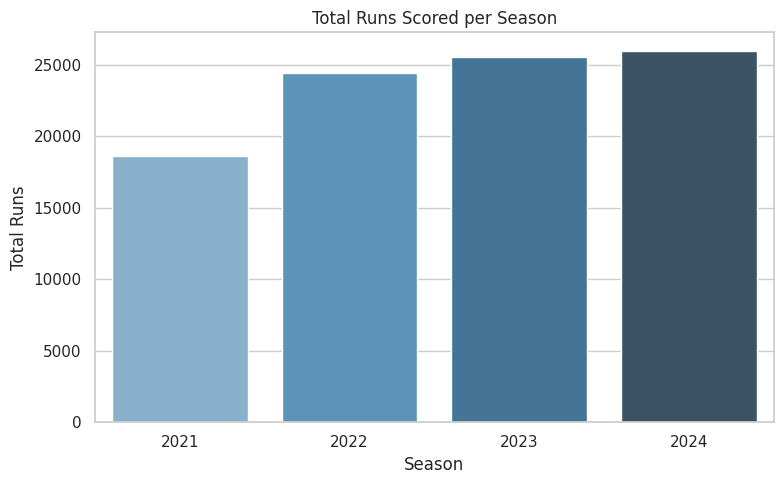

In [ ]:
# 4. Total Runs per Season
total_runs_season = deliveries_merged.groupby('season')['total_runs'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=total_runs_season, x='season', y='total_runs', palette='Blues_d')
plt.title("Total Runs Scored per Season")
plt.xlabel("Season")
plt.ylabel("Total Runs")
plt.tight_layout()
plt.show()

<ipython-input-7-eabb424983c3>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=most_wickets, x='wickets', y='bowler', palette='viridis')


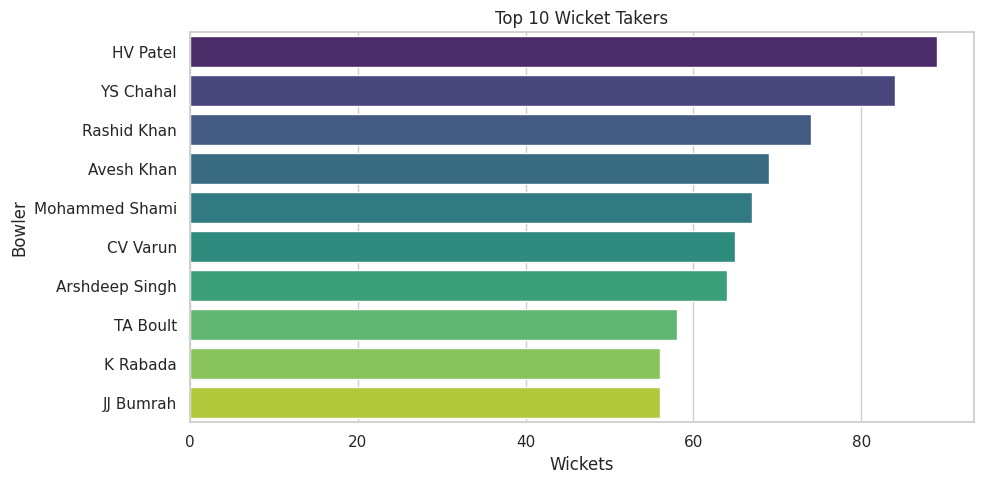

In [ ]:
# 5. Top 10 Wicket Takers
wicket_kinds = ['bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket']
wickets_df = deliveries_merged[deliveries_merged['dismissal_kind'].isin(wicket_kinds)]
most_wickets = wickets_df['bowler'].value_counts().head(10).reset_index()
most_wickets.columns = ['bowler', 'wickets']
plt.figure(figsize=(10, 5))
sns.barplot(data=most_wickets, x='wickets', y='bowler', palette='viridis')
plt.title("Top 10 Wicket Takers")
plt.xlabel("Wickets")
plt.ylabel("Bowler")
plt.tight_layout()
plt.show()

<ipython-input-8-9f2e90d13545>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_wins, x='wins', y='team', palette='crest')


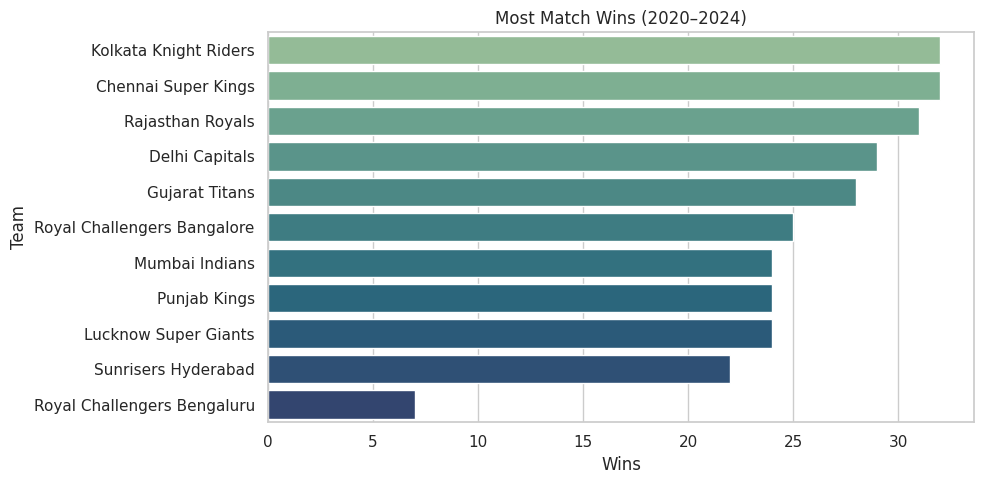

In [ ]:
# 6. Most Wins
team_wins = matches_filtered['winner'].value_counts().reset_index()
team_wins.columns = ['team', 'wins']
plt.figure(figsize=(10, 5))
sns.barplot(data=team_wins, x='wins', y='team', palette='crest')
plt.title("Most Match Wins (2020–2024)")
plt.xlabel("Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


<ipython-input-9-83f3ca6a7311>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_win_percent.sort_values('win_percentage', ascending=False), x='win_percentage', y='team', palette='coolwarm')


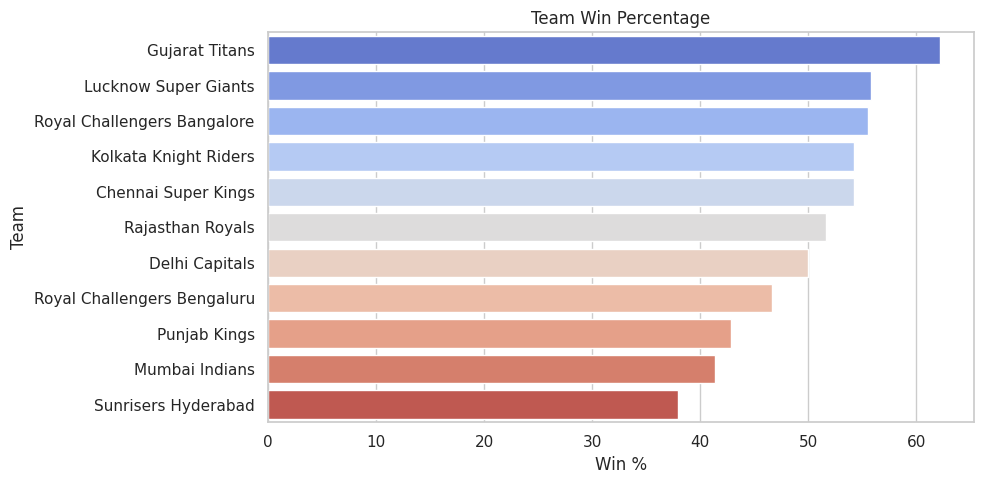

In [ ]:
# 7. Win Percentage
team1 = matches_filtered[['season', 'team1']].rename(columns={'team1': 'team'})
team2 = matches_filtered[['season', 'team2']].rename(columns={'team2': 'team'})
total_matches = pd.concat([team1, team2]).groupby('team').size().reset_index(name='matches_played')
team_win_percent = pd.merge(team_wins, total_matches, on='team')
team_win_percent['win_percentage'] = (team_win_percent['wins'] / team_win_percent['matches_played']) * 100
plt.figure(figsize=(10, 5))
sns.barplot(data=team_win_percent.sort_values('win_percentage', ascending=False), x='win_percentage', y='team', palette='coolwarm')
plt.title("Team Win Percentage")
plt.xlabel("Win %")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

<ipython-input-10-d3045e7a4ac4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fifty_percent, x='fifty_percent', y='batter', palette='rocket')


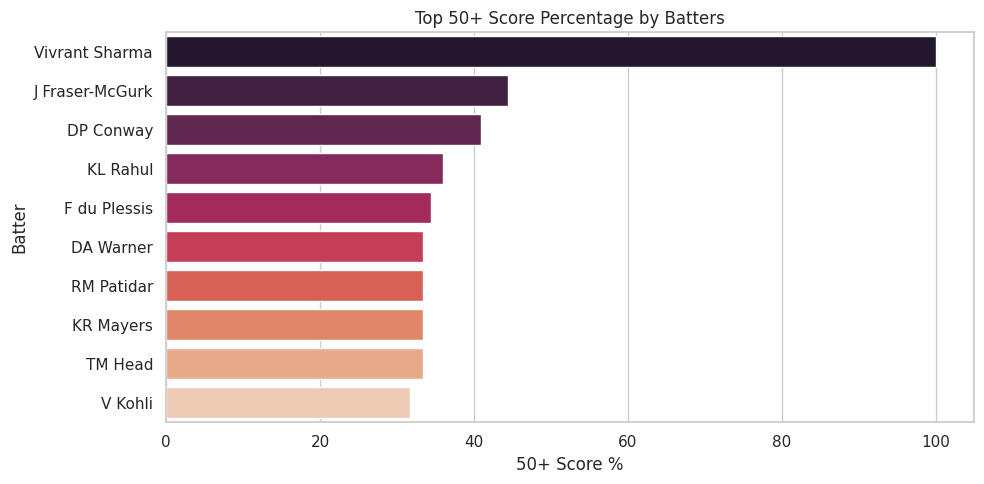

In [ ]:
# 8. 50+ Score Percentage
fifties = deliveries_merged.groupby(['match_id', 'batter'])['batsman_runs'].sum().reset_index()
fifties['is_50_plus'] = fifties['batsman_runs'] >= 50
fifty_counts = fifties.groupby('batter')['is_50_plus'].sum()
match_counts = fifties.groupby('batter').size()
fifty_percent = (fifty_counts / match_counts * 100).sort_values(ascending=False).head(10).reset_index()
fifty_percent.columns = ['batter', 'fifty_percent']
plt.figure(figsize=(10, 5))
sns.barplot(data=fifty_percent, x='fifty_percent', y='batter', palette='rocket')
plt.title("Top 50+ Score Percentage by Batters")
plt.xlabel("50+ Score %")
plt.ylabel("Batter")
plt.tight_layout()
plt.show()

<ipython-input-11-d26523877f53>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_wickets, x='wickets', y='team', palette='magma')


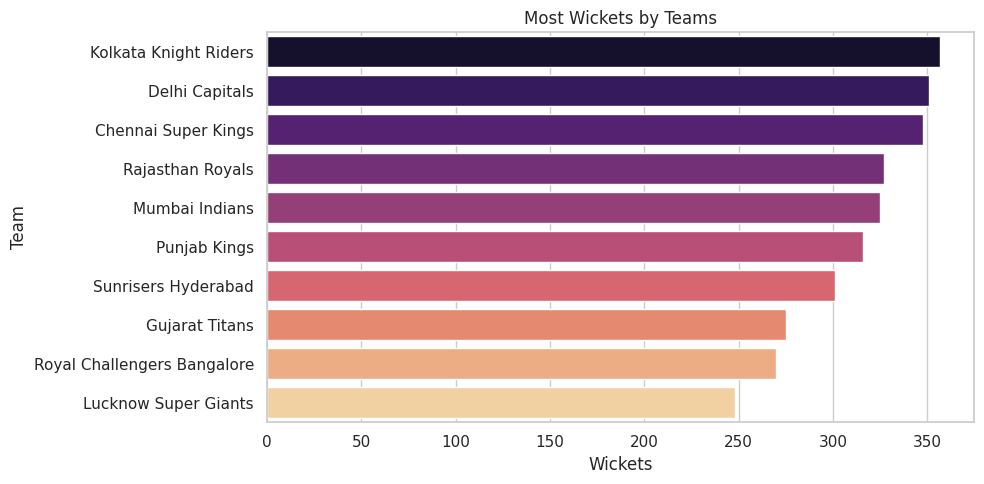

In [ ]:
# 9. Most Wickets by Team
team_wickets = wickets_df.groupby('bowling_team').size().sort_values(ascending=False).head(10).reset_index()
team_wickets.columns = ['team', 'wickets']
plt.figure(figsize=(10, 5))
sns.barplot(data=team_wickets, x='wickets', y='team', palette='magma')
plt.title("Most Wickets by Teams")
plt.xlabel("Wickets")
plt.ylabel("Team")
plt.tight_layout()
plt.show()

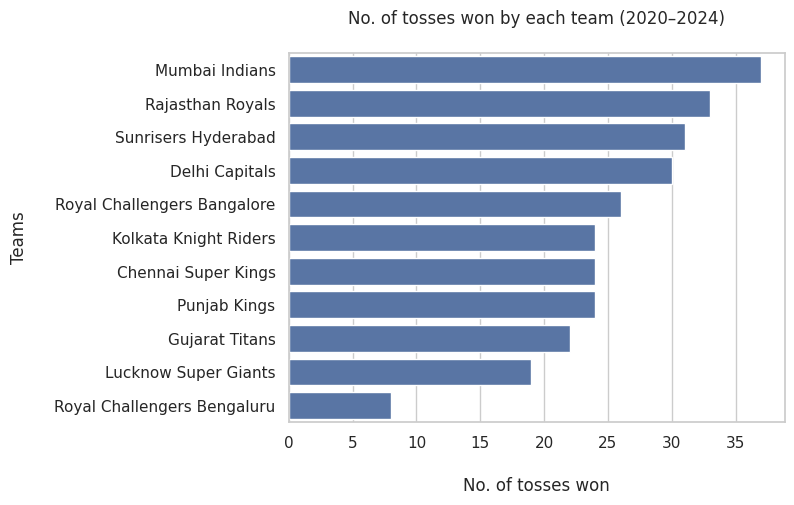

In [ ]:
# Plot to visualise the no. of tosses won by each team
# Toss wins from 2020 to 2024
filtered_matches = matches[matches['season'].between(2020, 2024)]
toss = filtered_matches['toss_winner'].value_counts()

# Plot toss wins
fig, ax = plt.subplots()
ax.set_title('No. of tosses won by each team (2020–2024)\n')
sns.barplot(y=toss.index, x=toss.values, orient='h')
plt.xlabel('\nNo. of tosses won')
plt.ylabel('Teams\n')
plt.show()


In [ ]:
# Filter matches between 2020 and 2024
filtered_matches = matches[matches['season'].between(2020, 2024)]

# Top 10 Player of the Match winners
mom = filtered_matches['player_of_match'].value_counts().head(10)
mom


,count
player_of_match,
RD Gaikwad,8
Shubman Gill,8
JC Buttler,7
RA Jadeja,7
SP Narine,6
KL Rahul,6
Kuldeep Yadav,6
F du Plessis,6
CV Varun,5


In [ ]:
# Filter matches between 2020 and 2024
filtered_matches = matches[matches['season'].between(2020, 2024)]

# Number of matches won by each team
winners = filtered_matches['winner'].value_counts()
winners


,count
winner,
Kolkata Knight Riders,32
Chennai Super Kings,32
Rajasthan Royals,31
Delhi Capitals,29
Gujarat Titans,28
Royal Challengers Bangalore,25
Mumbai Indians,24
Punjab Kings,24
Lucknow Super Giants,24
